In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns

from datetime import datetime
from scipy.optimize import minimize

try:
    # Try the new style name first
    plt.style.use('seaborn-v0_8')
except:
    # Fallback to other options
    available_styles = plt.style.available
    if 'seaborn' in available_styles:
        plt.style.use('seaborn')
    elif 'ggplot' in available_styles:
        plt.style.use('ggplot')
    else:
        plt.style.use('default')
sns.set()

In [3]:
# Load ETF Data 

data = pd.read_csv("../data/etf_data.csv", index_col=0, parse_dates=True)
returns = data.pct_change().dropna()

etfs = list(returns.columns)

In [4]:
# Equal Weighted Portfolio 

def equal_weight_portfolio(returns):
    weights = np.repeat(1/returns.shape[1], returns.shape[1])
    portfolio_returns = (returns * weights).sum(axis=1)
    return portfolio_returns

In [5]:
# Mean-Variance Optimization (Markowitz MPT) 

def negative_sharpe(weights, mean_returns, cov_matrix, risk_free_rate=0.01):
    ret = np.dot(weights, mean_returns)
    vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe = (ret - risk_free_rate) / vol
    return -sharpe

def optimize_portfolio_mpt(returns):
    mean_returns = returns.mean() * 252
    cov_matrix = returns.cov() * 252
    num_assets = len(mean_returns)
    
    bounds = tuple((0, 1) for _ in range(num_assets))
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    init_guess = num_assets * [1. / num_assets]

    result = minimize(negative_sharpe, init_guess,
                      args=(mean_returns, cov_matrix),
                      method='SLSQP', bounds=bounds,
                      constraints=constraints)
    
    mpt_weights = result.x
    mpt_returns = (returns * mpt_weights).sum(axis=1)
    return mpt_returns, mpt_weights

In [6]:
# Risk-Parity Strategy 

def risk_parity_weights(cov_matrix):
    vol = np.sqrt(np.diag(cov_matrix))
    inv_vol = 1 / vol
    weights = inv_vol / np.sum(inv_vol)
    return weights

def risk_parity_portfolio(returns):
    cov_matrix = returns.cov() * 252
    weights = risk_parity_weights(cov_matrix)
    rp_returns = (returns * weights).sum(axis=1)
    return rp_returns, weights

In [7]:
# Run Backtests 

eq_ret = equal_weight_portfolio(returns)
mpt_ret, mpt_weights = optimize_portfolio_mpt(returns)
rp_ret, rp_weights = risk_parity_portfolio(returns)

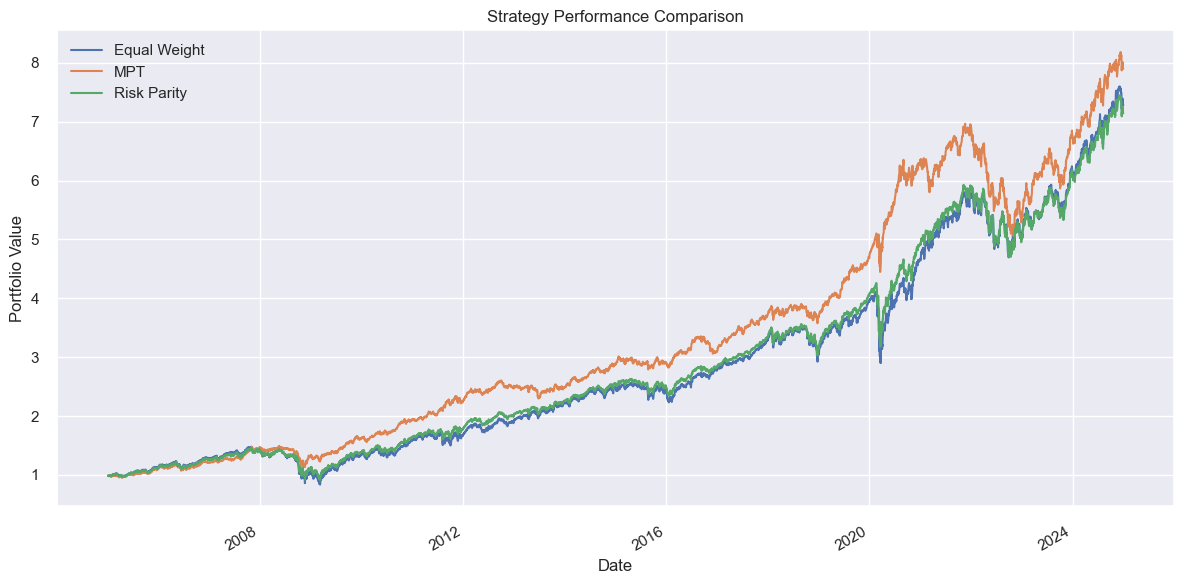

In [8]:
# Plot Results 

df_perf = pd.DataFrame({
    'Equal Weight': (1 + eq_ret).cumprod(),
    'MPT': (1 + mpt_ret).cumprod(),
    'Risk Parity': (1 + rp_ret).cumprod()
})

plt.figure(figsize=(12,6))
df_perf.plot(ax=plt.gca())
plt.title("Strategy Performance Comparison")
plt.ylabel("Portfolio Value")
plt.grid(True)
plt.tight_layout()
plt.savefig("../figures/day13_strategy_comparison.png")
plt.show()

In [9]:
# Save Final Returns for Dashboard or Evaluation 
df_perf.to_csv("../data/day13_strategy_returns.csv")